In [140]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'capstone:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5049605%2F8468971%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240602%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240602T150806Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D11114cf42d173c3aa597fa31a778b2e6ae6bef5c656ac16c3e2256751206417a28605bb9f74941f3acd911e66bae8ffde12c0d45f33fa842efc38a1b5a1530d696b6ae94108271d666af6c9982bfd10f802f6bb11fcf8c570767d3a789c6da77fa566715209d135a8e31f8d3e7c81124e7ac49376e1be3af2e4baabd53d80f4ede6f3b4e68271c81b9a67b79c78097c2ca1cff652f119e4f66d38690fff2ace0295532c73173b325e6559b290a10c2ed0e3b36643101d7c31113ee2861c82780c113f0fe0734e8bd49c948d02b535b588b4da81c08ad09f0c0c505ac9d2717ba71b0e369eebc9b6488aab2aaf2452ae81fe439b645c72442658eeada8053928b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 505783447 bytes downloaded
Downloaded and uncompressed: capstone
Data source import complete.


In [141]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display

In [142]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_data(csv_path, image_dir, image_height, image_width, batch_size, augment=False, class_mode='raw'):
    labels_df = pd.read_csv(csv_path)

    if augment:
        # augmentation
        datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            brightness_range=[0.5,1.5],
            fill_mode='nearest')
        # end augmentation
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_dataframe(
        dataframe=labels_df,
        directory=image_dir,
        x_col="filename",
        y_col=labels_df.columns[1:],
        target_size=(image_height, image_width),  # Update target size to match model's input shape
        batch_size=batch_size,
        class_mode='raw')

    return generator

train_dir = '/kaggle/input/capstone/train'
test_dir = '/kaggle/input/capstone/test'
valid_dir = '/kaggle/input/capstone/valid'

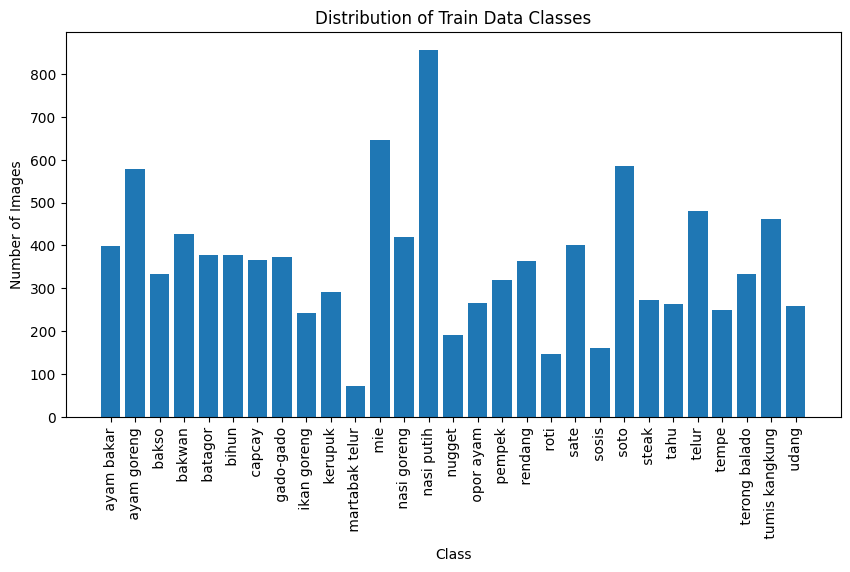

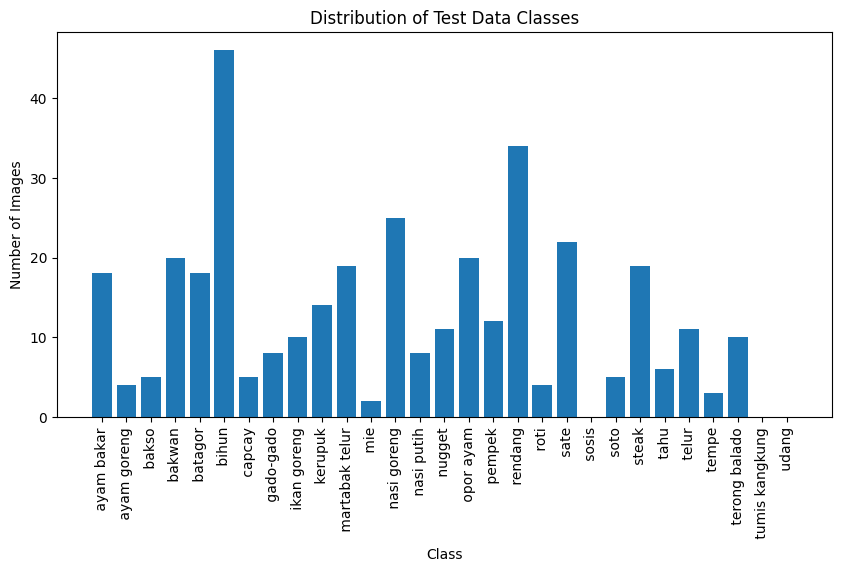

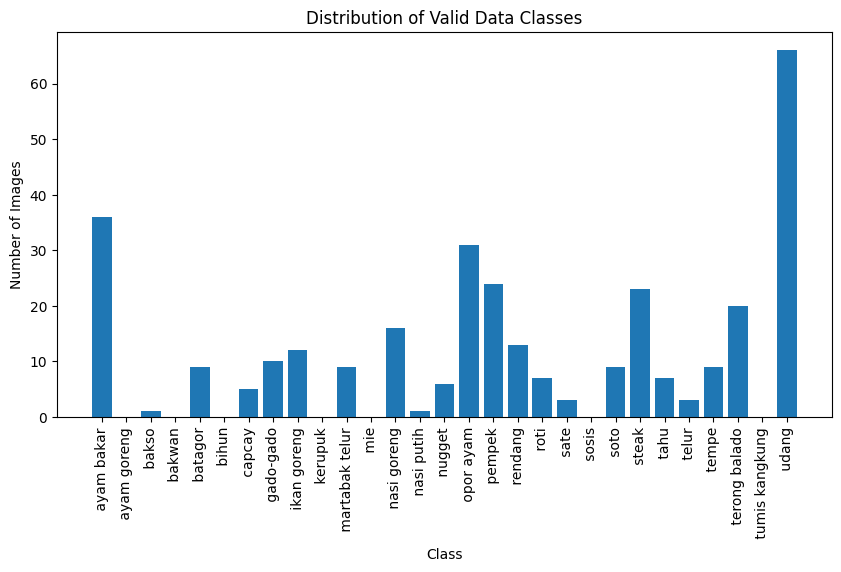

In [143]:
directories = {'Train': train_dir, 'Test': test_dir, 'Valid': valid_dir}

for dataset, directory in directories.items():
    labels_df = pd.read_csv(os.path.join(directory, '_classes.csv'))
    class_counts = labels_df.iloc[:, 1:].sum(axis=0)
    plt.figure(figsize=(10, 5))
    plt.bar(class_counts.index, class_counts.values)
    plt.title(f'Distribution of {dataset} Data Classes')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=90)
    plt.show()


In [144]:
train_generator = load_data(
    f'{train_dir}/_classes.csv',
    f'{train_dir}',
    image_height=224,
    image_width=224,
    batch_size=32,
    class_mode='raw',
    augment=True)

test_generator = load_data(
    f'{test_dir}/_classes.csv',
    f'{test_dir}',
    image_height=224,
    image_width=224,
    batch_size=32,
    class_mode='raw',
    augment=False)

valid_generator = load_data(
    f'{valid_dir}/_classes.csv',
    f'{valid_dir}',
    image_height=224,
    image_width=224,
    batch_size=32,
    class_mode='raw',
    augment=False)


Found 8552 validated image filenames.
Found 325 validated image filenames.
Found 315 validated image filenames.


In [145]:
classes_df = pd.read_csv(f"{train_dir}/_classes.csv")

display(classes_df)



,filename,ayam bakar,ayam goreng,bakso,bakwan,batagor,bihun,capcay,gado-gado,ikan goreng,...,sate,sosis,soto,steak,tahu,telur,tempe,terong balado,tumis kangkung,udang
0,IMG_7640_JPG_jpg.rf.000c68085c9dff4825199d36b9...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,sate-375-_jpg.rf.001287e26ae11eaaf0bebf5ea4dba...,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,qqqq-11baef38830b06df9080e83bf4c1936e_600x400_...,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Image_20-2-_jpg.rf.000e8c3d49ed2fb4f1c71b08c1b...,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,24208429_1_jpg.rf.00250edbe2e57edf66ef1025652e...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8547,IMG_7738_JPG_jpg.rf.c58142b3a2435787b2e498ce9c...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8548,gurame-goreng-sambal-pecak-foto-resep-utama_jp...,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8549,197344710-188015679997435-695189602164340637-n...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8550,warenkunde_wurst_1_quelle_alnatura_fotograf_ol...,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


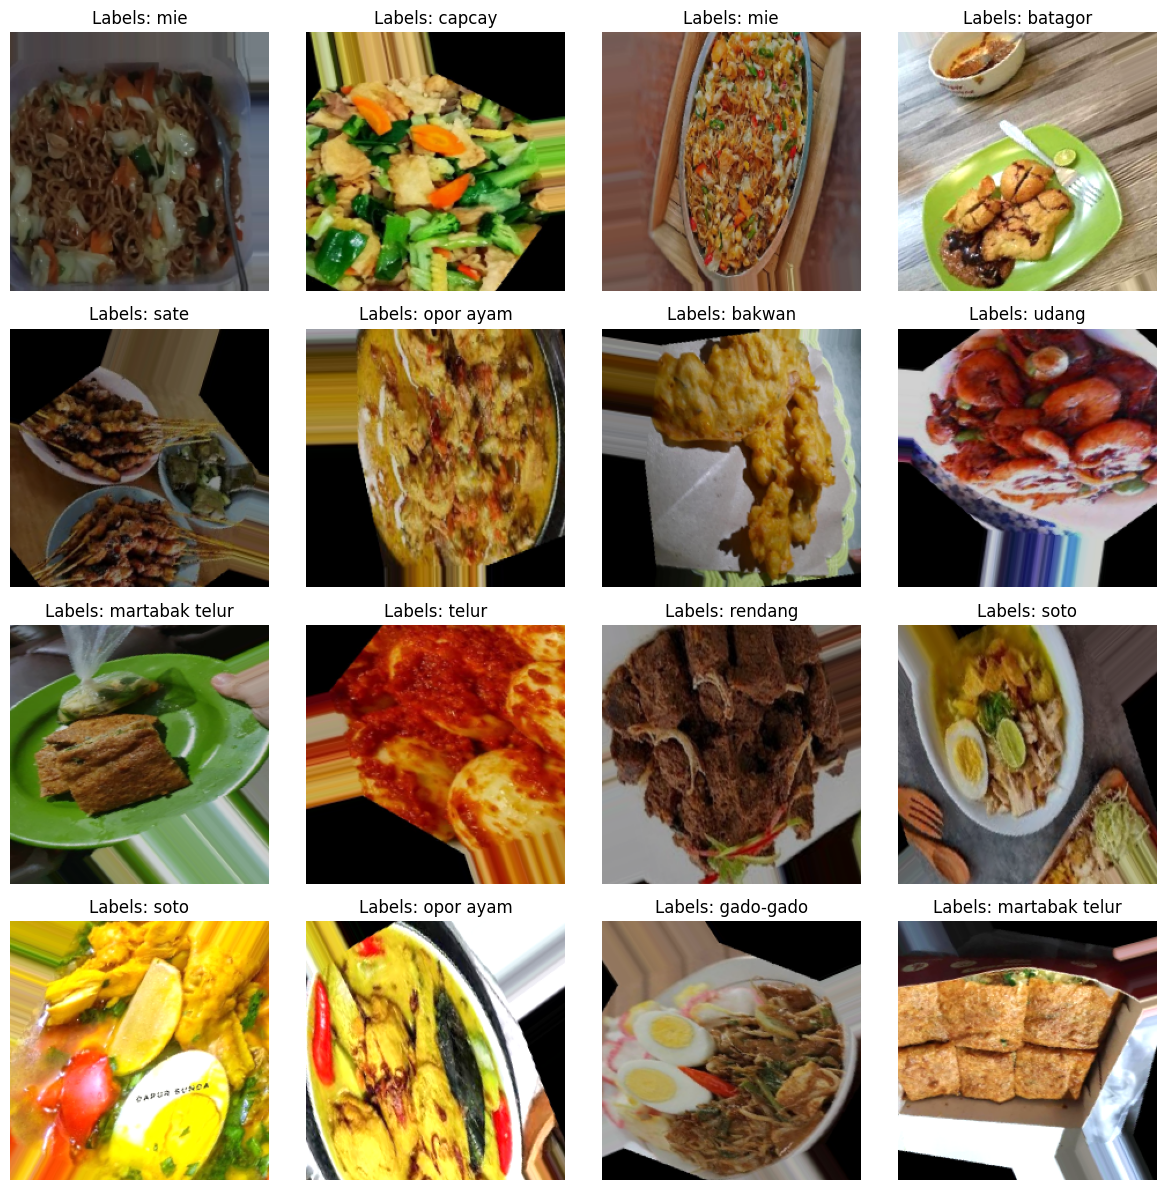

In [146]:
num_rows, num_cols = 4, 4
num_images_to_display = 16

label_dict = {
    0: 'ayam bakar', 1: 'ayam goreng', 2: 'bakso', 3: 'bakwan', 4: 'batagor',
    5: 'bihun', 6: 'capcay', 7: 'gado-gado', 8: 'ikan goreng', 9: 'kerupuk',
    10: 'martabak telur', 11: 'mie', 12: 'nasi goreng', 13: 'nasi putih',
    14: 'nugget', 15: 'opor ayam', 16: 'pempek', 17: 'rendang', 18: 'roti',
    19: 'sate', 20: 'sosis', 21: 'soto', 22: 'steak', 23: 'tahu', 24: 'telur',
    25: 'tempe', 26: 'terong balado', 27: 'tumis kangkung', 28: 'udang'
}

images, labels = next(train_generator)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
axes = axes.flatten()

for i in range(num_images_to_display):
    ax = axes[i]
    image = images[i]
    label = labels[i]

    if image.max() <= 1.0:
        image = (image * 255).astype('uint8')

    ax.imshow(image)

    decoded_labels = [label_dict[j] for j, val in enumerate(label) if val == 1]
    ax.set_title(f"Labels: {', '.join(decoded_labels)}")

    ax.axis('off')

plt.tight_layout()
plt.show()


In [147]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers, models,Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(29, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate = 0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),f1_score])

model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_25 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_25[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']     

In [148]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_path = "best_model.h5"

checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      monitor='val_loss',
                                      verbose=2,
                                      save_best_only=True,
                                      mode='min')

early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        patience=5,
                                        verbose=2,
                                        mode='min',
                                        restore_best_weights=True)


In [149]:
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=valid_generator,
                    callbacks=[checkpoint_callback, early_stopping_callback], workers = 32)


Epoch 1/15
268/268 [==============================] - ETA: 0s - loss: 0.1688 - accuracy: 0.2304 - precision_24: 0.2955 - recall_24: 0.0701
Epoch 1: val_loss improved from inf to 0.10234, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


268/268 [==============================] - 238s 857ms/step - loss: 0.1688 - accuracy: 0.2304 - precision_24: 0.2955 - recall_24: 0.0701 - val_loss: 0.1023 - val_accuracy: 0.4857 - val_precision_24: 0.8679 - val_recall_24: 0.1437
Epoch 2/15
267/268 [============================>.] - ETA: 0s - loss: 0.1065 - accuracy: 0.5072 - precision_24: 0.7824 - recall_24: 0.2917
Epoch 2: val_loss improved from 0.10234 to 0.07857, saving model to best_model.h5
268/268 [==============================] - 149s 538ms/step - loss: 0.1064 - accuracy: 0.5077 - precision_24: 0.7826 - recall_24: 0.2922 - val_loss: 0.0786 - val_accuracy: 0.6063 - val_precision_24: 0.8425 - val_recall_24: 0.3344
Epoch 3/15
268/268 [==============================] - ETA: 0s - loss: 0.0887 - accuracy: 0.5975 - precision_24: 0.7894 - recall_24: 0.4108
Epoch 3: val_loss improved from 0.07857 to 0.07125, saving model to best_model.h5
268/268 [==============================] - 148s 528ms/step - loss: 0.0887 - accuracy: 0.5975 - preci

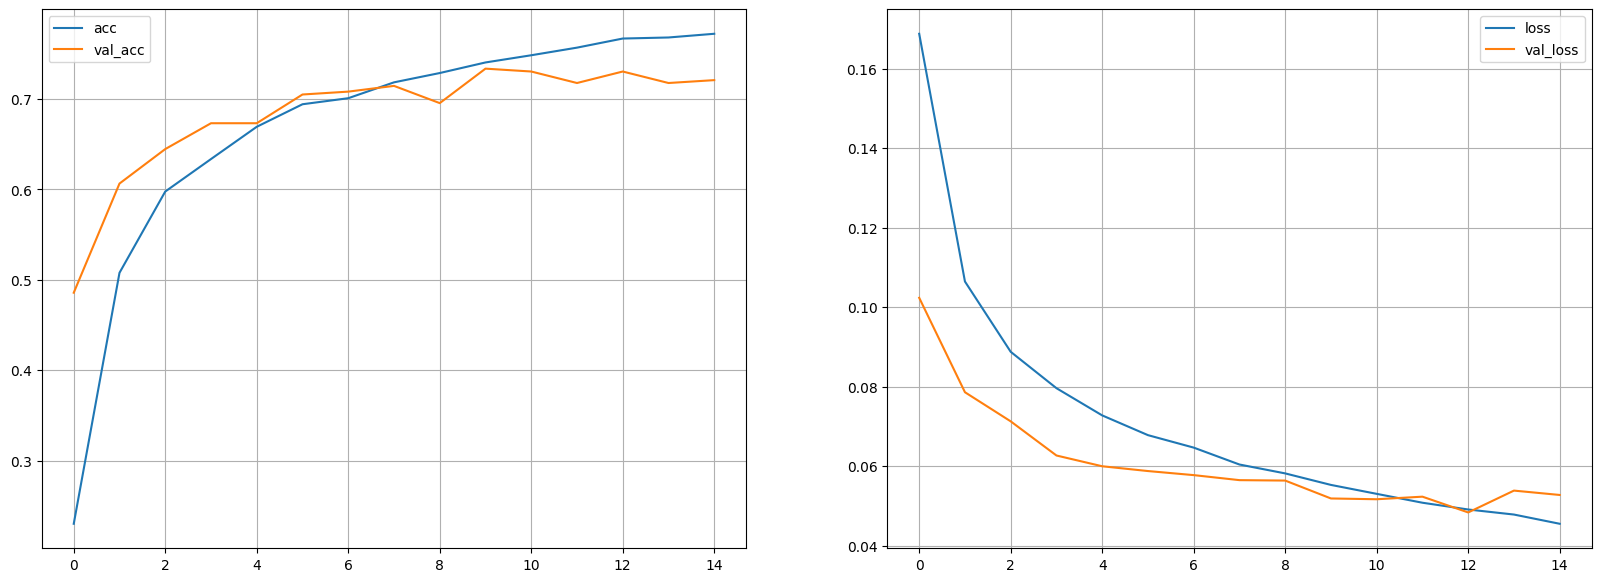

In [150]:
result_history = history.history
fig = plt.figure(figsize = (20, 7))
plt.subplot(121)
plt.plot(result_history['accuracy'], label = 'acc')
plt.plot(result_history['val_accuracy'], label = 'val_acc')
plt.grid()
plt.legend()

plt.subplot(122)
plt.plot(result_history['loss'], label = 'loss')
plt.plot(result_history['val_loss'], label = 'val_loss')
plt.grid()
plt.legend()

10/10 [==============================] - 2s 114ms/step


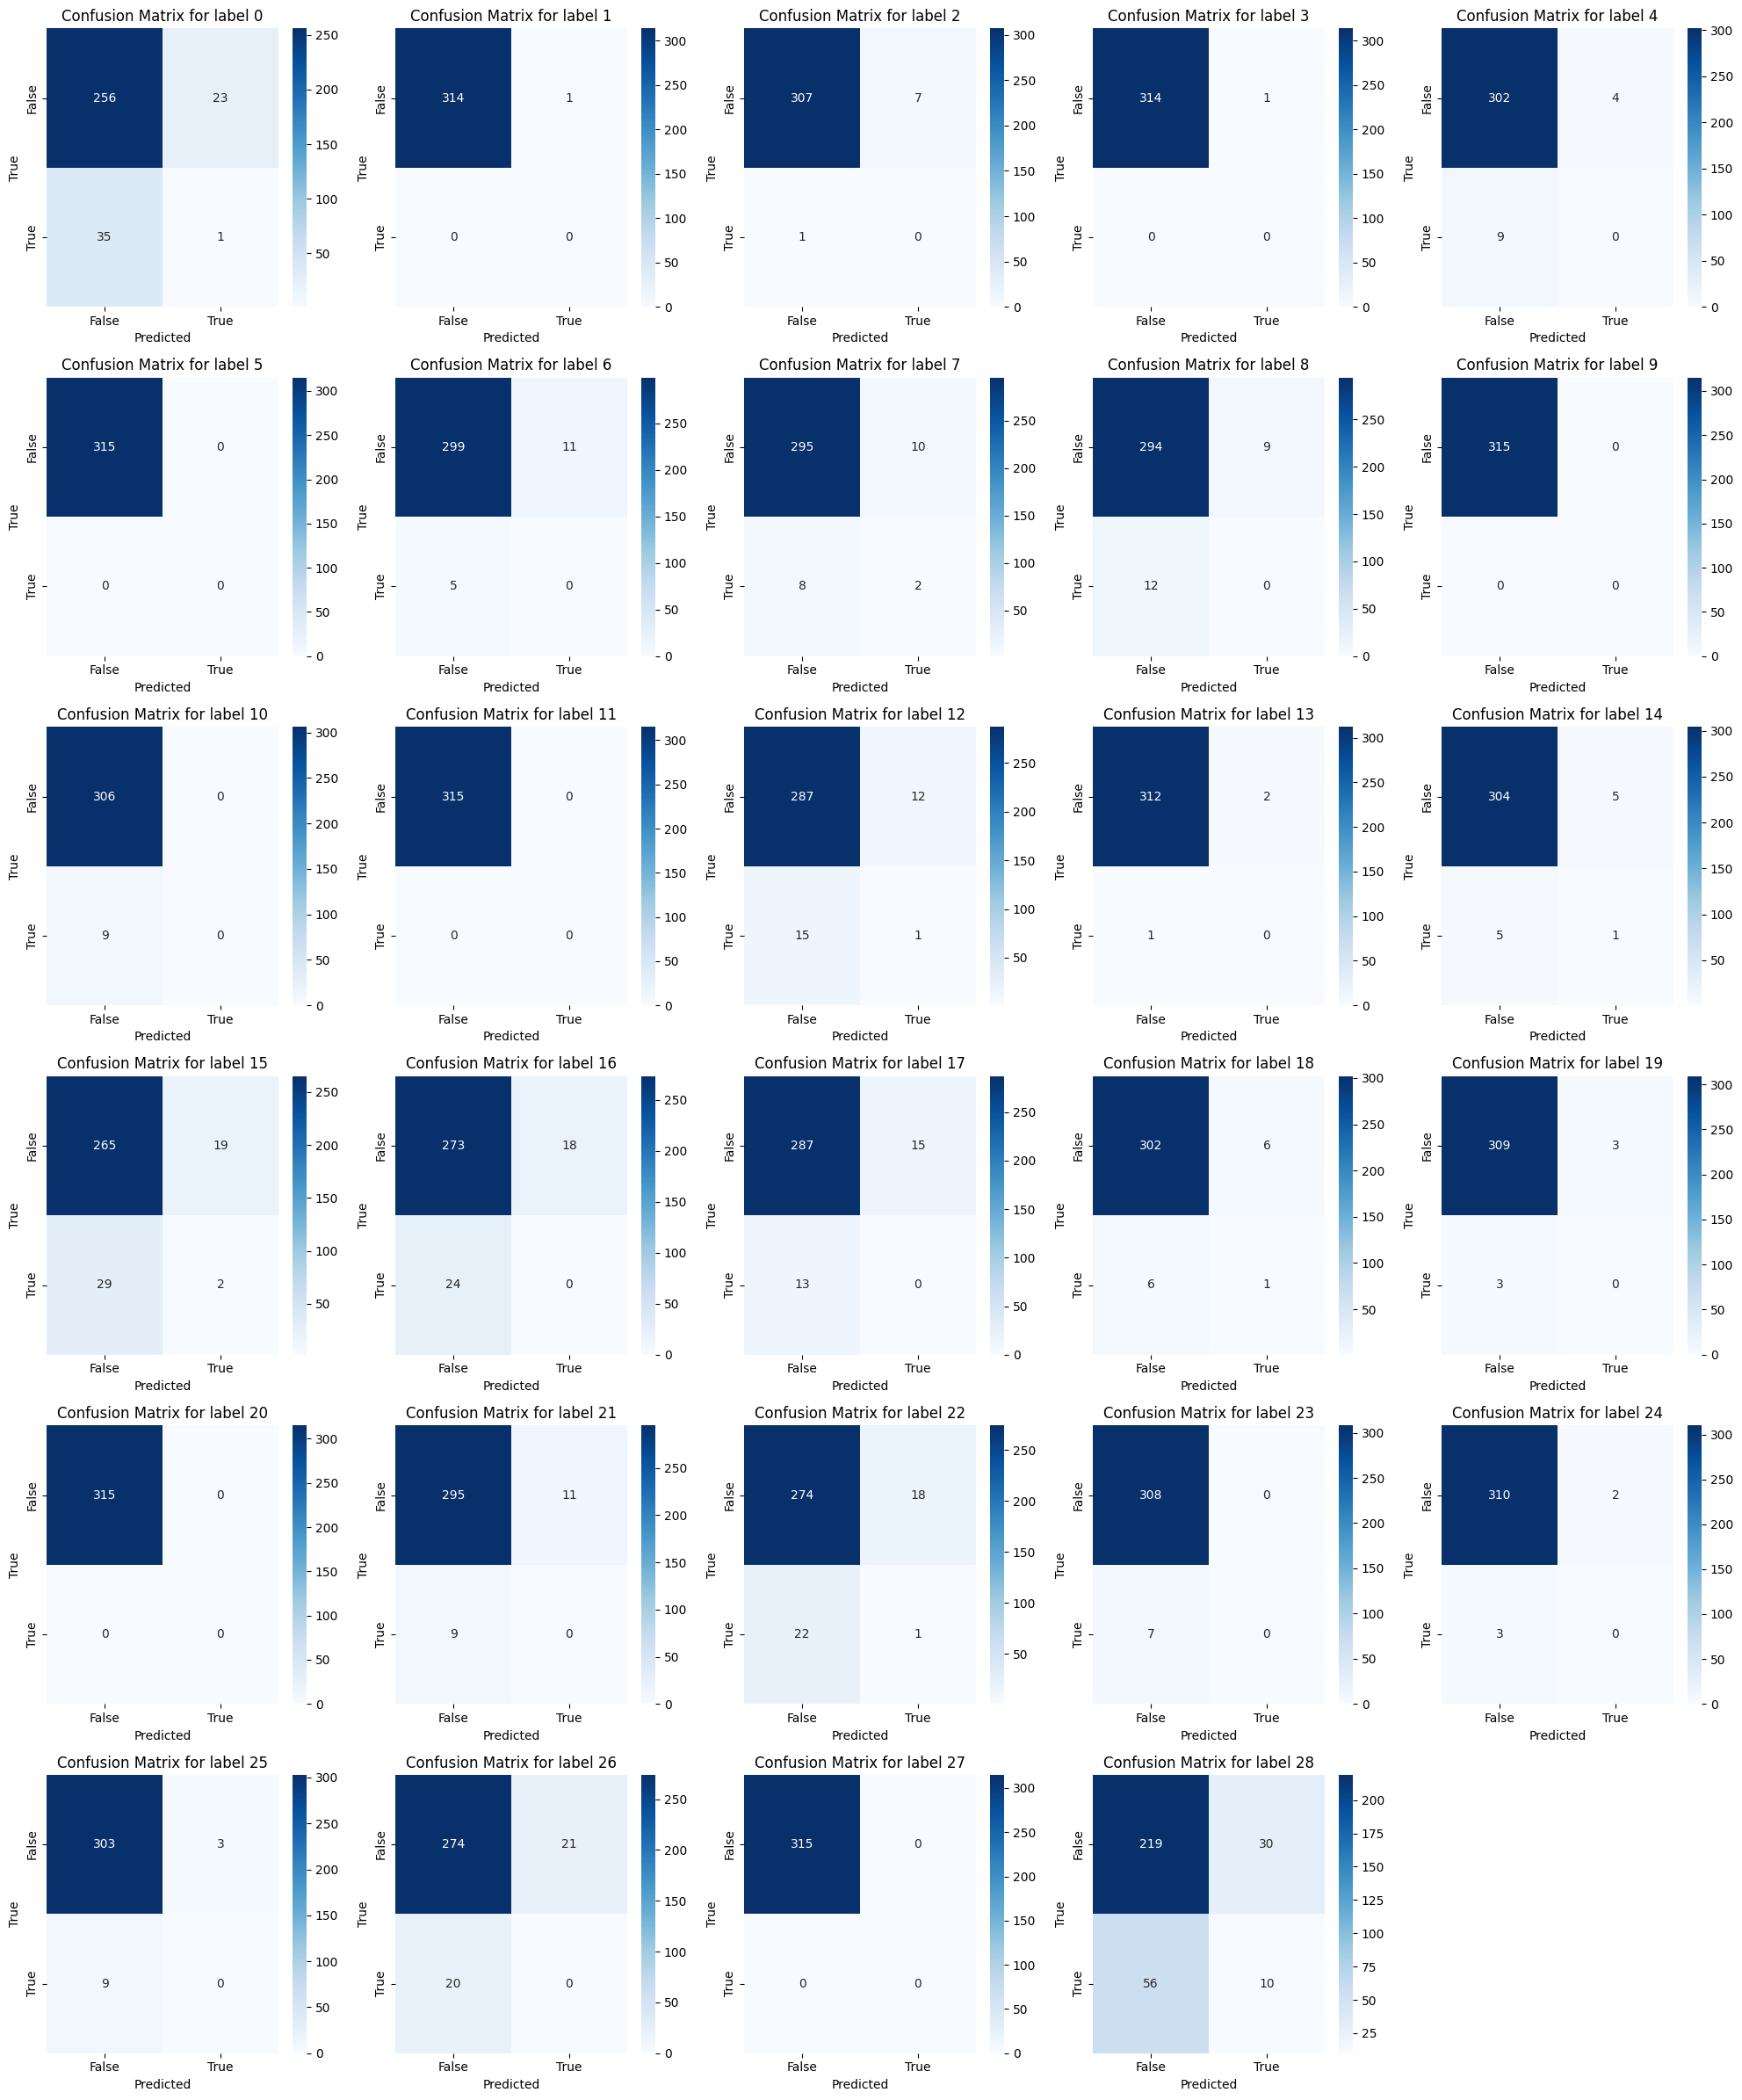

In [154]:
from google.colab import files
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

best_model = load_model("best_model.h5")

y_pred = best_model.predict(valid_generator)
y_true = valid_generator.labels

y_pred_binary = (y_pred > 0.5).astype(int)

mcm = multilabel_confusion_matrix(y_true, y_pred_binary)

num_labels = len(mcm)
cols = 5
rows = (num_labels + cols - 1) // cols

plt.figure(figsize=(20, rows * 4))
for i, cm in enumerate(mcm):
    plt.subplot(rows, cols, i + 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['False', 'True'], yticklabels=['False', 'True'])
    plt.title(f'Confusion Matrix for label {i}')
    plt.xlabel('Predicted')
    plt.ylabel('True')

plt.tight_layout()
plt.show()


11/11 [==============================] - 3s 157ms/step - loss: 0.0508 - accuracy: 0.7477 - precision_24: 0.8597 - recall_24: 0.6657
Test Accuracy: [0.05075686052441597, 0.7476922869682312, 0.8597122430801392, 0.6657381653785706]
11/11 [==============================] - 2s 108ms/step
predicted: 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
True: 
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


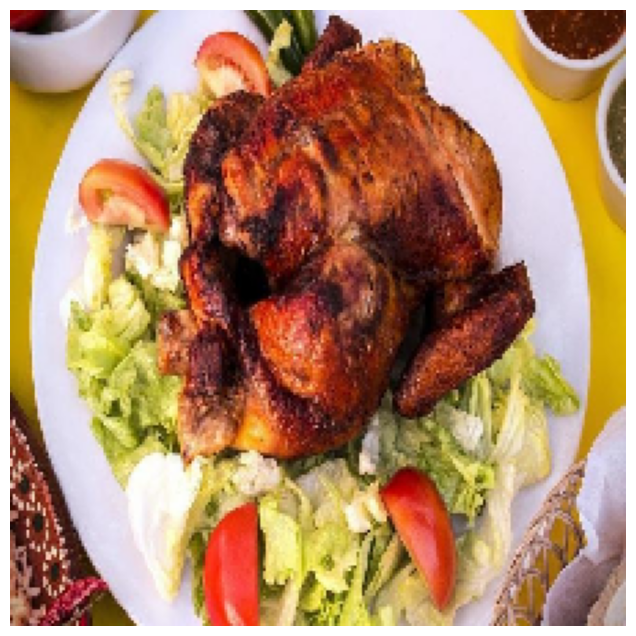

In [159]:
from tensorflow.keras.models import load_model

best_model = load_model("best_model.h5")
eval = best_model.evaluate(test_generator)

print("Test Accuracy:", eval)

num_images = 1

predictions = best_model.predict(test_generator)
predicted_labels = (predictions > 0.5).astype("int32")

test_images, test_labels = next(test_generator)

plt.figure(figsize=(15, 8))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(test_images[i])
    print(f'predicted: \n{predicted_labels[i]}')
    print(f'True: \n{test_labels[i]}')
    plt.axis("off")
plt.show()


In [ ]:
files.download("best_model.h5")

In [ ]:
best_model = load_model("best_model.h5")

converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()

tflite_model_path = "best_model.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)


print(f"Model converted to TFLite and saved at {tflite_model_path}")


In [ ]:
# Download the file
files.download(tflite_model_path)